# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [1]:
from copy import deepcopy
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from src.sim.scenario import Scenario
from src.sim.processing import SingleSimProcessor
from src.metrics import DEFAULT_METRICS
from src.logging import get_logger

logger = get_logger(__name__)

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

In [2]:
# Generate markets and prices
market_names = ["wstETH", "wbtc"]
scenario = Scenario("baseline_macro", market_names)
print(
    f"Running {scenario.num_steps} steps with frequency {scenario.pricepaths.config['freq']}."
)

[INFO][19:44:57][src.sim.scenario]-35539: Fetching wstETH market from subgraph
[INFO][19:45:00][src.sim.scenario]-35539: Market snapshot as 2024-01-09 18:17:35
[INFO][19:45:00][src.sim.scenario]-35539: Bands snapshot as 2024-01-09 19:03:23
[INFO][19:45:00][src.sim.scenario]-35539: Users snapshot as 2024-01-09 15:29:23
[INFO][19:45:00][src.sim.scenario]-35539: Fetching wbtc market from subgraph
[INFO][19:45:03][src.sim.scenario]-35539: Market snapshot as 2024-01-09 18:17:35
[INFO][19:45:03][src.sim.scenario]-35539: Bands snapshot as 2024-01-09 19:03:23
[INFO][19:45:03][src.sim.scenario]-35539: Users snapshot as 2024-01-09 15:29:23
[INFO][19:45:17][src.sim.scenario]-35539: Using 368400 1Inch quotes from 2023-11-19 19:00:00 to 2023-12-19 19:00:00
[INFO][19:45:18][src.utils.poolgraph]-35539: Found 30 valid trading cycles of length 3.


Running 365 steps with frequency 1d.


In [3]:
scenario.prepare_for_run()

[DEBUG][19:45:18][src.agents.arbitrageur]-35539: Executing arbitrage: Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=crvUSD, amt=92735954257546517151744), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=crvUSD, out=USDC, amt=92484868375221034263689), Swap(pool=External Market (TUSD, USDC), in=USD Coin, out=TrueUSD, amt=92364083898)], Expected Profit: 54.444726324966716).
[DEBUG][19:45:18][src.trades.cycle]-35539: Executing cycle Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=crvUSD, amt=92735954257546517151744), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=crvUSD, out=USDC, amt=92484868375221034263689), Swap(pool=External Market (TUSD, USDC), in=USD Coin, out=TrueUSD, amt=92364083898)], Expected Profit: 54.444726324966716).
[DEBUG][19:45:18][src.trades.cycle]-35539: Executed trade Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=crvUSD, amt=92735954257546517151744). Amt out: 9248486837522

In [21]:
print(scenario.liquidator.paths)
_scenario = deepcopy(scenario)
print(_scenario.liquidator.paths)

{'0x100daa78fc509db39ef7d04de0c1abd299f4c6ce': [Path(basis_token=TokenDTO(address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', name='USD Coin', symbol='USDC', decimals=6, min_trade_size=1000.0, max_trade_size=100000000.0), crvusd_pool=<SimCurveStableSwapPool address=0x4dece678ceceb27446b35c672dc7d61f30bad69e chain=mainnet>, collat_pool=External Market (wstETH, USDC)), Path(basis_token=TokenDTO(address='0xdac17f958d2ee523a2206206994597c13d831ec7', name='Tether USD', symbol='USDT', decimals=6, min_trade_size=1000.0, max_trade_size=100000000.0), crvusd_pool=<SimCurveStableSwapPool address=0x390f3595bca2df7d23783dfd126427cceb997bf4 chain=mainnet>, collat_pool=External Market (wstETH, USDT))], '0x4e59541306910ad6dc1dac0ac9dfb29bd9f15c67': [Path(basis_token=TokenDTO(address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', name='USD Coin', symbol='USDC', decimals=6, min_trade_size=1000.0, max_trade_size=100000000.0), crvusd_pool=<SimCurveStableSwapPool address=0x4dece678ceceb27446b35c672dc7d61f

In [22]:
scenario.liquidator.paths["0x100daa78fc509db39ef7d04de0c1abd299f4c6ce"]

[Path(basis_token=TokenDTO(address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', name='USD Coin', symbol='USDC', decimals=6, min_trade_size=1000.0, max_trade_size=100000000.0), crvusd_pool=<SimCurveStableSwapPool address=0x4dece678ceceb27446b35c672dc7d61f30bad69e chain=mainnet>, collat_pool=External Market (wstETH, USDC)),
 Path(basis_token=TokenDTO(address='0xdac17f958d2ee523a2206206994597c13d831ec7', name='Tether USD', symbol='USDT', decimals=6, min_trade_size=1000.0, max_trade_size=100000000.0), crvusd_pool=<SimCurveStableSwapPool address=0x390f3595bca2df7d23783dfd126427cceb997bf4 chain=mainnet>, collat_pool=External Market (wstETH, USDT))]

In [13]:
processor = SingleSimProcessor(scenario, DEFAULT_METRICS)
processor.initial_state

{'timestamp': Timestamp('2024-01-09 23:29:20'),
 'controller_wstETH Bad Debt': 0.0,
 'controller_WBTC Bad Debt': 0.0,
 'Bad Debt': 0.0,
 'controller_wstETH System Health': 0.5688939631345825,
 'controller_WBTC System Health': 1.2639003570536302,
 'System Health': 0.8834678729562805,
 'Borrower Loss': 0.0,
 'Hard Liquidation Losses': 0,
 'Soft Liquidation Losses': 0.0,
 'Value Leakage': 0.0,
 'Keeper Profit': 0.0,
 'Keeper Count': 0,
 'Liquidator Profit': 0.0,
 'Liquidator Count': 0,
 'Arbitrageur Profit': 0.0,
 'Arbitrageur Count': 0,
 'Peg Strength': 0.9989755158691714,
 'stableswap_crvUSD_TUSD Price': 1.0022483699329223,
 'stableswap_crvUSD_USDP Price': 0.9997488381582356,
 'stableswap_crvUSD_USDC Price': 0.9990873911861279,
 'stableswap_crvUSD_USDT Price': 0.9986535232730541,
 'Collateral Liquidated': 0,
 'Debt Repaid': 0,
 'Liquidation Count': 0,
 'pk_crvUSD/TUSD Debt': 0.0,
 'pk_crvUSD/USDP Debt': 0.0,
 'pk_crvUSD/USDC Debt': 0.0,
 'pk_crvUSD/USDT Debt': 0.0,
 'PK Debt': 0.0,
 'co

In [14]:
# def custom_autopct(pct):
#     return "{:.1f}%".format(pct) if pct > 5 else ""


# controller = scenario.controller
# total_debt = 0
# loans = {}
# for user, loan in controller.loan.items():
#     debt = loan.initial_debt / 1e18
#     loans[user] = debt
#     total_debt += debt

# thresh = 0.05 * total_debt
# loans = dict(sorted(loans.items(), key=lambda x: x[1], reverse=True))
# labels = [a if loans[a] > thresh else "" for a in loans.keys()]
# f, ax = plt.subplots()
# pie = ax.pie(loans.values(), labels=labels, autopct=custom_autopct)
# ax.set_title(f"{scenario.market_name} Loan Distribution")

### Run the Sim

In [15]:
import cProfile
import pstats

with cProfile.Profile() as pr:
    for sample in scenario.pricepaths:
        scenario.prepare_for_trades(sample)  # update prices/timestamps
        scenario.perform_actions(sample)  # arbitrage, liquidate, update
        processor.update(sample.timestamp, inplace=True)  # collect metrics

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.CUMULATIVE)
stats.print_stats()

         170601698 function calls (170450898 primitive calls) in 74.682 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      365    0.001    0.000   66.291    0.182 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/sim/scenario.py:322(perform_actions)
      365    0.004    0.000   58.987    0.162 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:35(arbitrage)
     1799    0.077    0.000   58.882    0.033 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:79(find_best_arbitrage)
    53970    0.077    0.000   58.668    0.001 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:130(optimize)
    45332    0.143    0.000   50.805    0.001 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:262(_optimize_mem)
    38056    0.186    0.000   50.067    0.001 /Users/tncintra/Desk

In [16]:
results = processor.process()

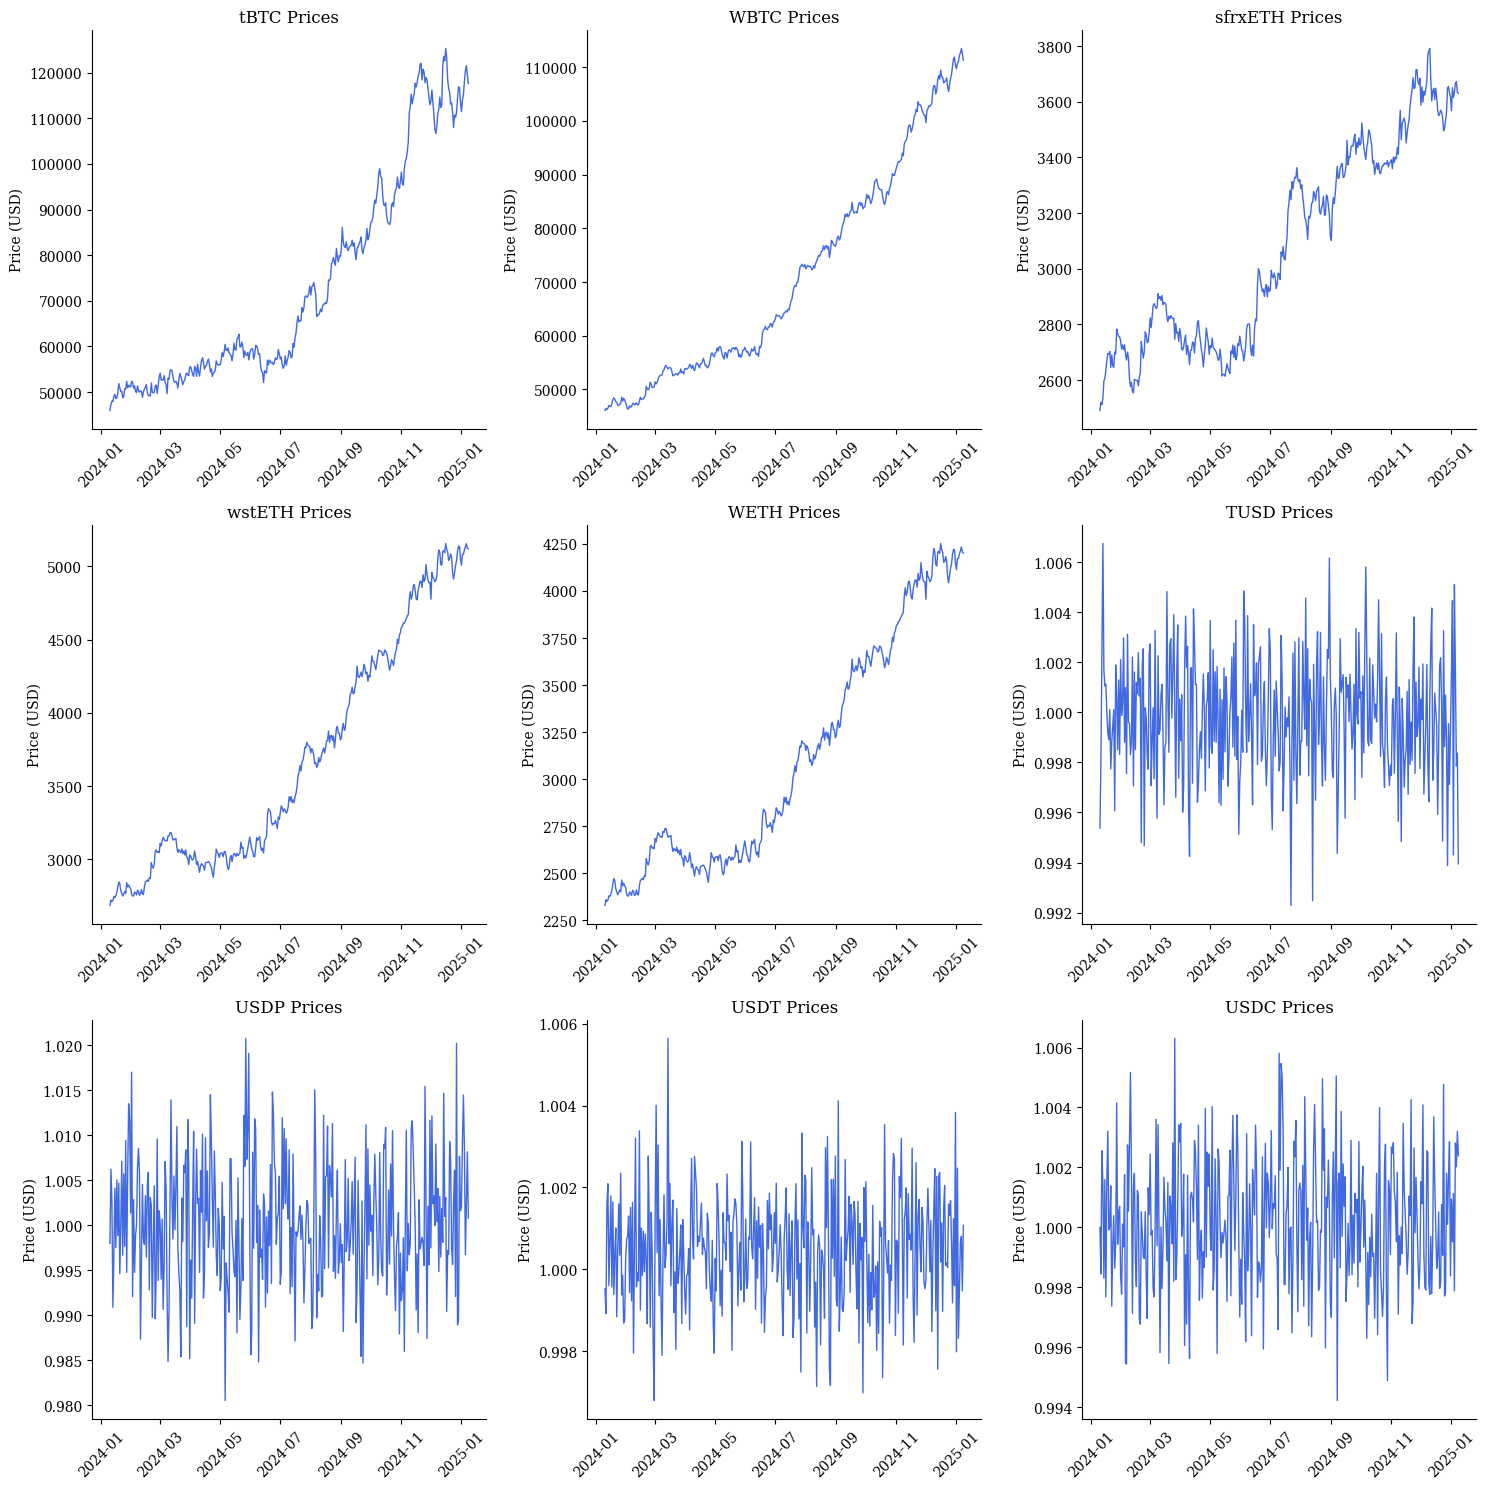

In [17]:
results.plot_prices()

In [18]:
df = results.df
# df.to_csv("../data/results.csv")
df.tail()

,Bad Debt,controller_wstETH Bad Debt,controller_WBTC Bad Debt,System Health,controller_wstETH System Health,controller_WBTC System Health,Borrower Loss,Hard Liquidation Losses,Soft Liquidation Losses,Value Leakage,Keeper Profit,Keeper Count,Liquidator Profit,Liquidator Count,Arbitrageur Profit,Arbitrageur Count,Peg Strength,stableswap_crvUSD_TUSD Price,stableswap_crvUSD_USDP Price,stableswap_crvUSD_USDC Price,stableswap_crvUSD_USDT Price,Collateral Liquidated,Debt Repaid,Liquidation Count,PK Debt,pk_crvUSD/TUSD Debt,pk_crvUSD/USDP Debt,pk_crvUSD/USDC Debt,pk_crvUSD/USDT Debt,Total Debt,controller_wstETH Total Debt,controller_WBTC Total Debt,llamma_wstETH Price,llamma_wstETH Oracle Price,llamma_WBTC Price,llamma_WBTC Oracle Price
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-03 23:29:20,0.0,0.0,0.0,2.740135,1.621372,4.093120,1705.131198,0,1705.131198,2.642173e+06,44.481598,5,0.0,0,2.642129e+06,1418,0.998805,0.993532,0.989525,0.999595,0.999196,0,0,0,0.0,0.0,0.0,0.0,0.0,6.208451e+07,3.398381e+07,2.810070e+07,12857.447315,5116.901945,536629.769296,112302.576718
2025-01-04 23:29:20,0.0,0.0,0.0,2.744370,1.624437,4.098769,1705.131198,0,1705.131198,2.649815e+06,44.481598,5,0.0,0,2.649770e+06,1423,0.999361,0.998229,1.003082,0.998400,0.999656,0,0,0,0.0,0.0,0.0,0.0,0.0,6.208451e+07,3.398381e+07,2.810070e+07,12906.454820,5124.948165,538538.381040,112458.658002
2025-01-05 23:29:20,0.0,0.0,0.0,2.768260,1.635685,4.137949,1705.131198,0,1705.131198,2.653356e+06,44.481598,5,0.0,0,2.653312e+06,1427,0.999064,1.001019,0.997207,0.998356,0.999656,0,0,0,0.0,0.0,0.0,0.0,0.0,6.208451e+07,3.398381e+07,2.810070e+07,13071.562509,5148.260574,550901.241217,113335.979797
2025-01-06 23:29:20,0.0,0.0,0.0,2.735342,1.615808,4.089260,1705.131198,0,1705.131198,2.655162e+06,44.481598,5,0.0,0,2.655117e+06,1431,0.998166,1.001051,0.992248,0.997395,1.000207,0,0,0,0.0,0.0,0.0,0.0,0.0,6.208451e+07,3.398381e+07,2.810070e+07,12796.605509,5113.405393,535936.558215,112323.395846
2025-01-07 23:29:20,0.0,0.0,0.0,2.711160,1.615773,4.035875,1705.131198,0,1705.131198,2.658263e+06,44.481598,5,0.0,0,2.658219e+06,1434,0.999489,1.005196,0.998946,0.997395,0.999836,0,0,0,0.0,0.0,0.0,0.0,0.0,6.208451e+07,3.398381e+07,2.810070e+07,12801.830950,5115.622785,519823.600226,111209.094952


In [19]:
results.metric_map

{'BadDebtMetric': 0,
 'SystemHealthMetric': 1,
 'BorrowerLossMetric': 2,
 'ValueLeakageMetric': 3,
 'PegStrengthMetric': 4,
 'LiquidationsMetric': 5,
 'PegKeeperMetric': 6,
 'MiscMetric': 7}

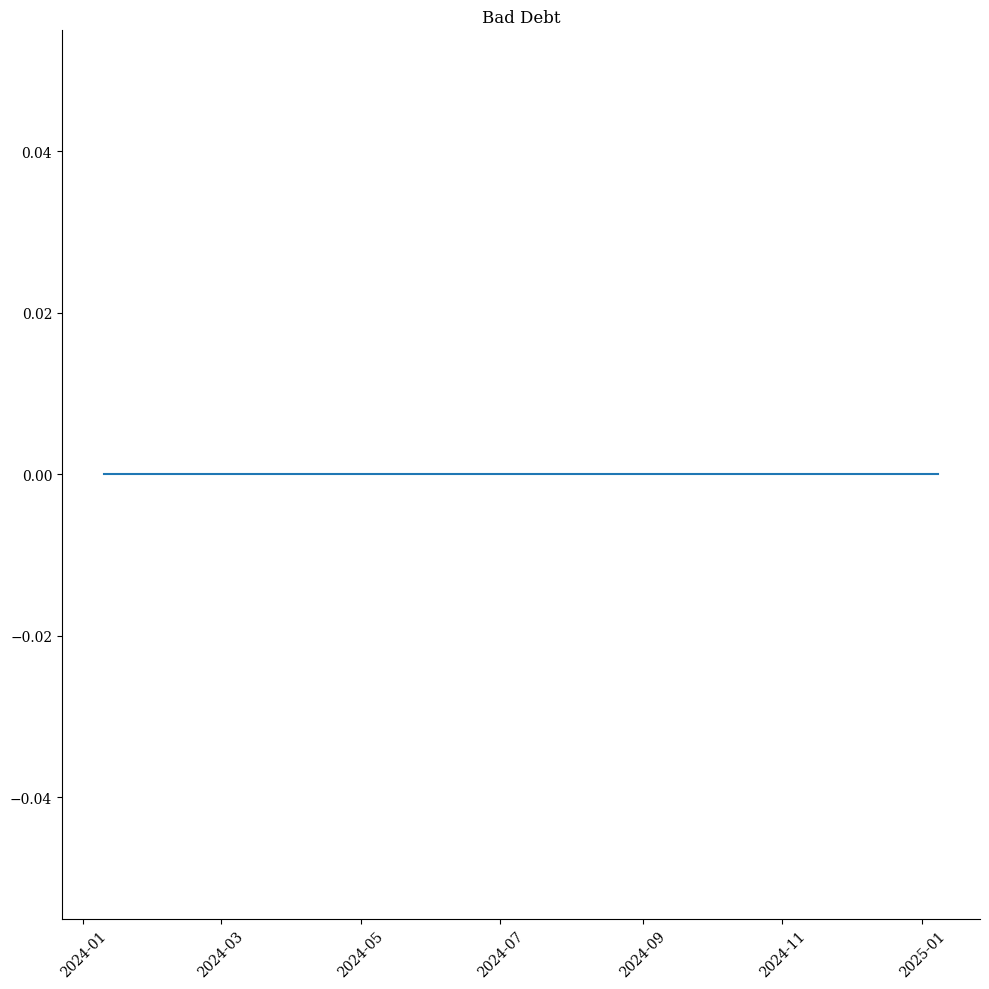

<Axes: title={'center': 'Bad Debt'}>

In [20]:
results.plot_metric(0, show=True)

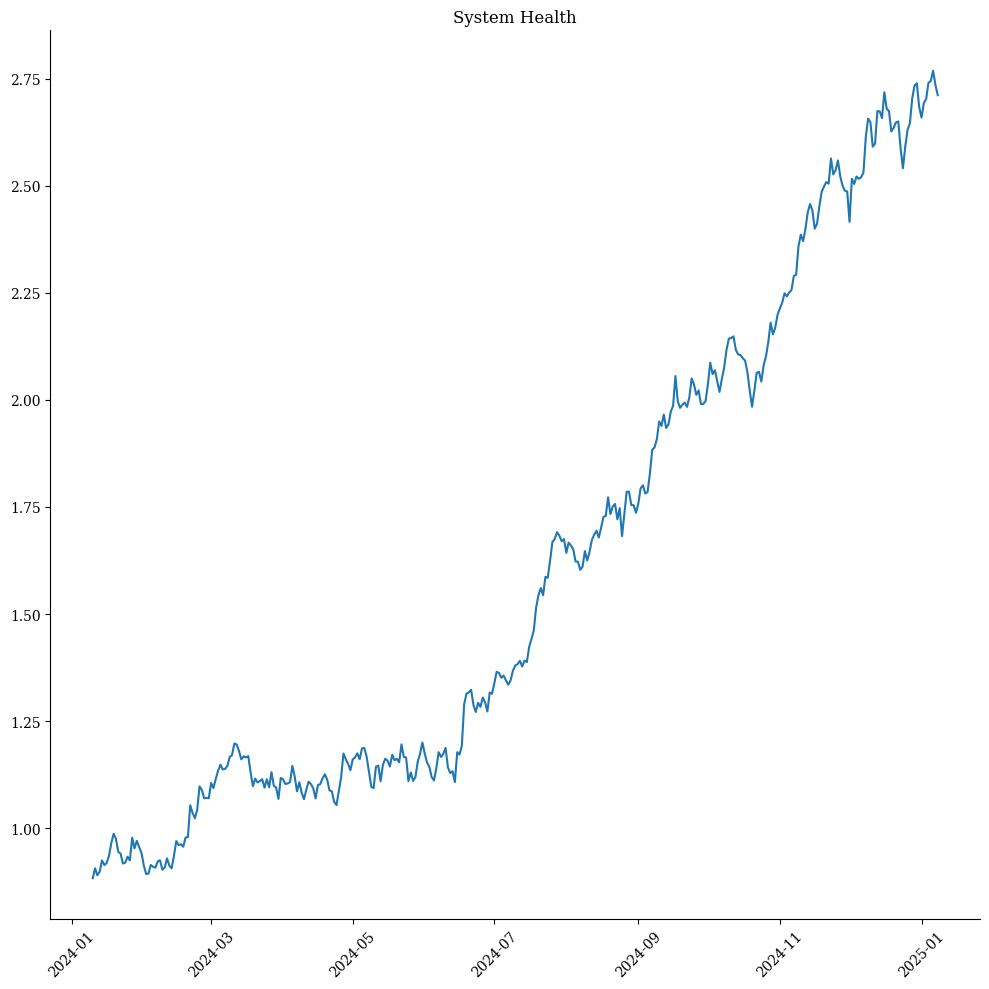

<Axes: title={'center': 'System Health'}>

In [21]:
results.plot_metric(1, show=True)

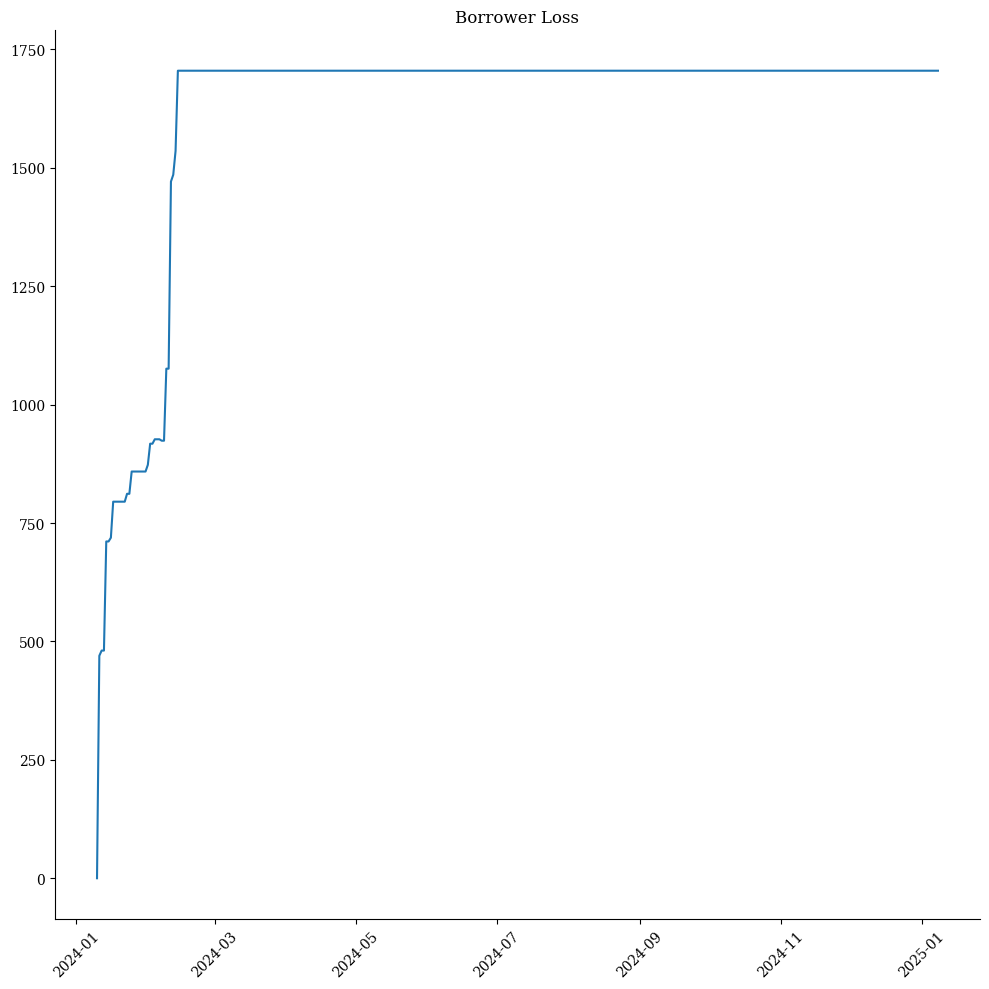

<Axes: title={'center': 'Borrower Loss'}>

In [22]:
results.plot_metric(2, show=True)

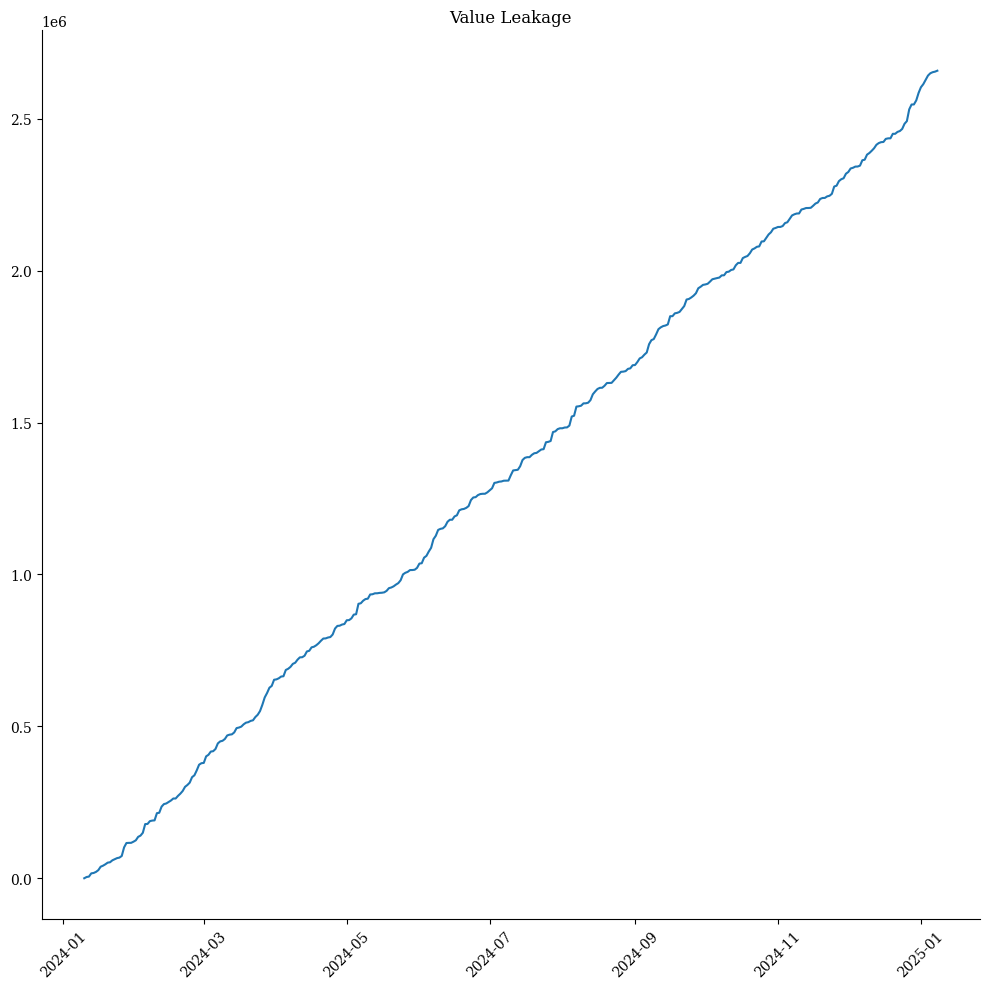

<Axes: title={'center': 'Value Leakage'}>

In [23]:
results.plot_metric(3, show=True)  # seems broken from crvusdsim

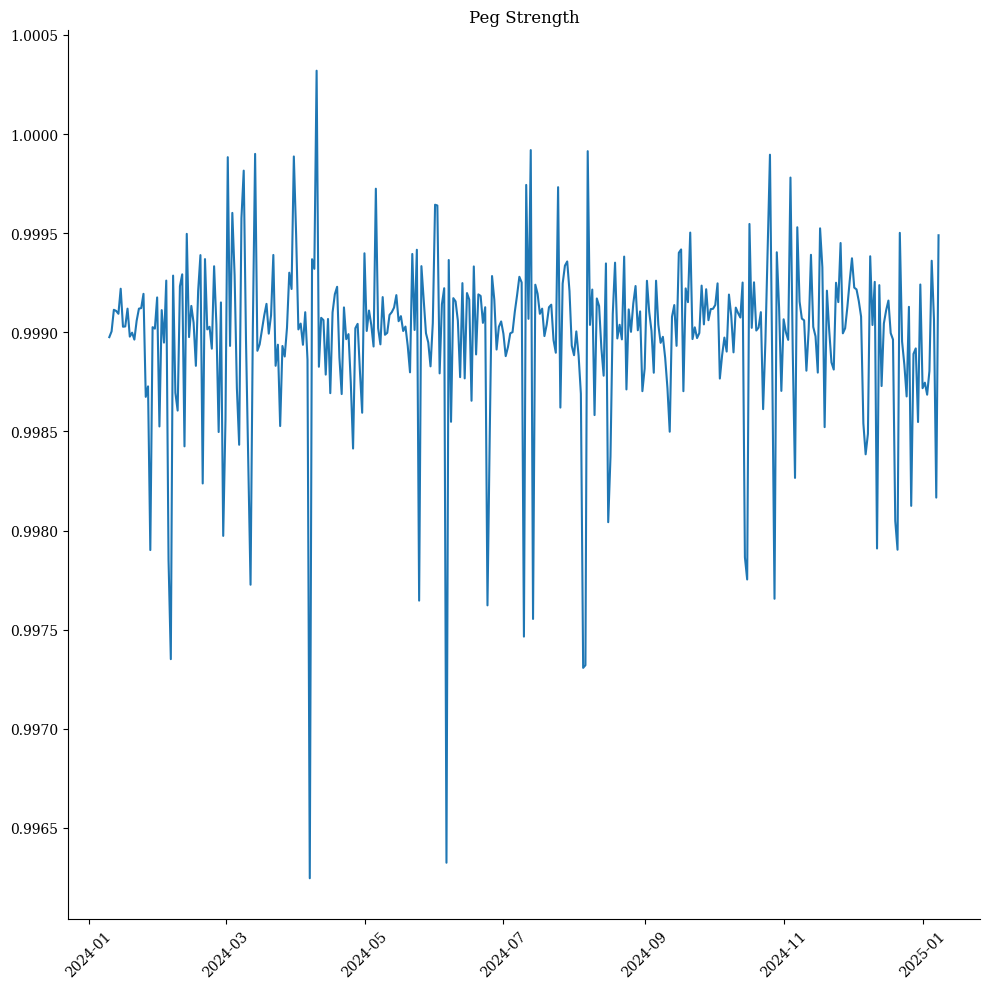

<Axes: title={'center': 'Peg Strength'}>

In [24]:
results.plot_metric(4, show=True)

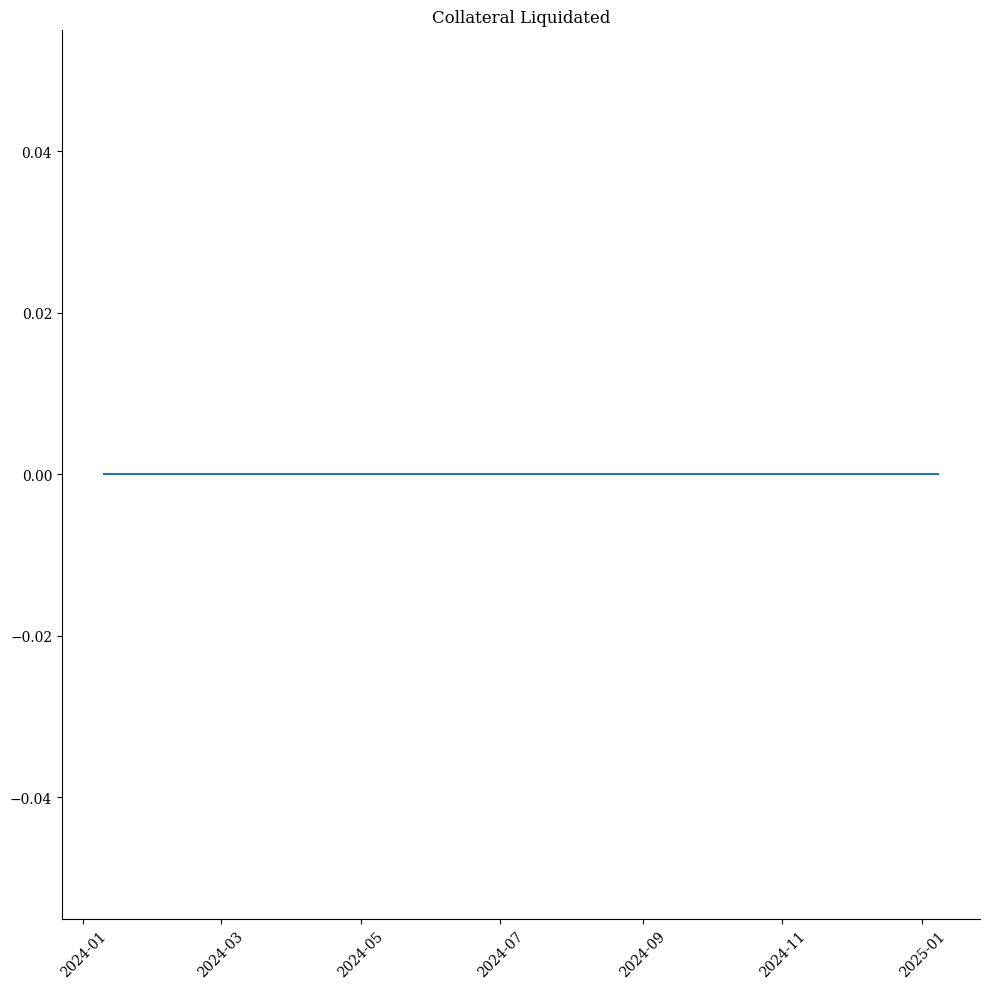

<Axes: title={'center': 'Collateral Liquidated'}>

In [25]:
results.plot_metric(5, show=True)

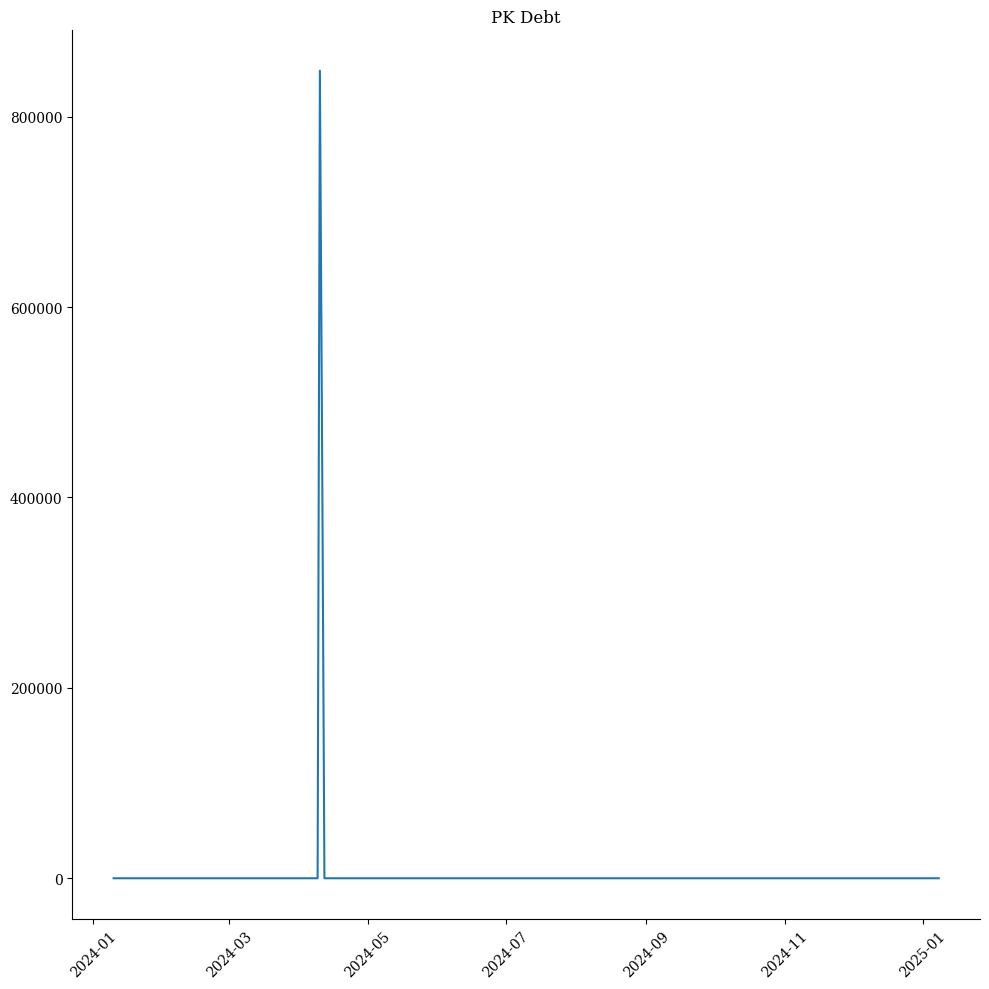

<Axes: title={'center': 'PK Debt'}>

In [26]:
results.plot_metric(6, show=True)

In [27]:
summary = results.summary.T
summary.columns = ["value"]
summary

,value
Bad Debt Max,0.000000e+00
Bad Debt Mean,0.000000e+00
Controller_Wsteth Bad Debt Max,0.000000e+00
Controller_Wsteth Bad Debt Mean,0.000000e+00
Controller_Wbtc Bad Debt Max,0.000000e+00
Controller_Wbtc Bad Debt Mean,0.000000e+00
System Health Mean,1.604996e+00
System Health Min,8.834679e-01
Controller_Wsteth System Health Mean,9.996681e-01
Controller_Wsteth System Health Min,5.688940e-01


In [28]:
df.columns

Index(['Bad Debt', 'controller_wstETH Bad Debt', 'controller_WBTC Bad Debt',
       'System Health', 'controller_wstETH System Health',
       'controller_WBTC System Health', 'Borrower Loss',
       'Hard Liquidation Losses', 'Soft Liquidation Losses', 'Value Leakage',
       'Keeper Profit', 'Keeper Count', 'Liquidator Profit',
       'Liquidator Count', 'Arbitrageur Profit', 'Arbitrageur Count',
       'Peg Strength', 'stableswap_crvUSD_TUSD Price',
       'stableswap_crvUSD_USDP Price', 'stableswap_crvUSD_USDC Price',
       'stableswap_crvUSD_USDT Price', 'Collateral Liquidated', 'Debt Repaid',
       'Liquidation Count', 'PK Debt', 'pk_crvUSD/TUSD Debt',
       'pk_crvUSD/USDP Debt', 'pk_crvUSD/USDC Debt', 'pk_crvUSD/USDT Debt',
       'Total Debt', 'controller_wstETH Total Debt',
       'controller_WBTC Total Debt', 'llamma_wstETH Price',
       'llamma_wstETH Oracle Price', 'llamma_WBTC Price',
       'llamma_WBTC Oracle Price'],
      dtype='object')